Inherited from:
* `/code/NOX_Make_lightcurves.ipynb`, that produced output (simulated light curves) to `/data_products/Simulated_DRW_Kozlowski/SDSS(OGLE)/190208_light_curves/` 
  * note : `/code2/Fig2_simulate_lcs.ipynb` is an offshoot that instead of using the same cadence for all light curves uses a real cadence of the SDSS-PS1 combined light curves ('../data_products/Combined_LC/'), and real errors. It produces simulated LCs in '../dp2/Fig2_simLC_SDSS-PS1/'.  In principle, one could make Fig.2 for a cadence of each of the 9000 real combined SDSS-PS1 light curves, simulate the recovery of input DRW parameters for that particular set of  (cadence , errors),  and thus have an `error` on the recovered DRW params. I run that for 88 light curves, saving the grid of 10000 simulated LCs in a dict lcname.npy. 
* `/code/NOX_Calc_Fig2.ipynb` , that took the simulated SDSS, OGLE light curves , and run DRW model with Celerite, saving the full log-posterior 2D space for each light curve to `/data_products/Simulated_DRW_Kozlowski/SDSS(OGLE)/190208_results_celerite/`
   * note: `code2/Fig2_fit_lcs.ipynb` is an offshoot, that fits the light curves simulated  with realistic cadence different for each S82 light curve - output of `/code2/Fig2_simulate_lcs.ipynb` above 
* `/code/PLOT_Fig2_George_Celerite.ipynb`  

# Fig.1 : Recovery of the input DRW timescale

In [10]:
%%html
<div style="display:flex">
     <div style="flex:1;padding-right:5px;">
          <img src="figs/fig01a.pdf">
     </div>
     <div style="flex:1;padding-left:5px;">
          <img src="figs/fig01b.pdf">
     </div>
</div>
<!-- more info https://www.xaprb.com/blog/how-to-style-images-with-markdown/ , 
    and  https://html.com  >

TOC :
* [Part 1 : simulate DRW light curves, subsample at SDSS/OGLE cadence ](#part1)
* [Part 2 : fit DRW model to simulated light curves  ](#part2)
* [Part 3 : plot the figure summarizing the fit vs input](#part3)

## --> Part 1 : simulate  ideal DRW signal (0 mean, no uncertainty) light curves <a id='part1'></a>

(this was already run once so no need to run again...)

( code below taken directly from `../code/N0X_Make_lightcurves.ipynb`)

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from astropy.table import Table
import imp
mod = imp.load_source('modules.py', '../code/modules.py')
import os 

**a)** Simulate SDSS cadence with N=60 points, or OGLE cadence with  N=445 points

60 60
445 445


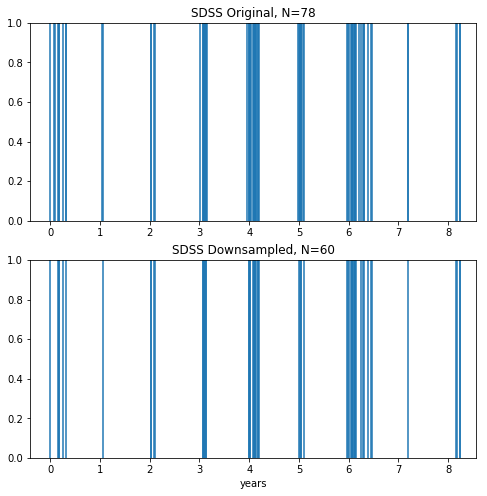

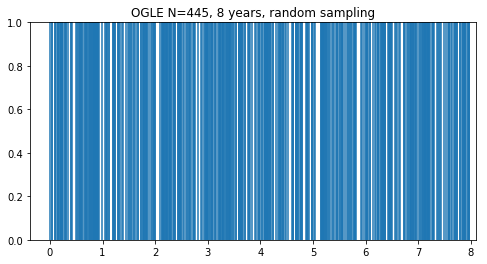

In [12]:
%matplotlib inline
# this has only names of QSOs...
#sdss_qso = fetch_dr7_quasar()

# the light curves are here 
# The S82 QSO light curves 
# http://faculty.washington.edu/ivezic/macleod/qso_dr7/Southern.html

# grab SDSS sampling from a random light curve ...
sdss = Table.read('../raw_data/SDSS_QSO/1000679', format='ascii')
sdss_times = sdss['col1'][1:]
sdss_times = sdss_times - min(sdss_times) # start from 0 

# add to the end of the light curve the same 
t = np.array(sdss_times) 
t = np.append(t, t[-1]+t[1:])

# select points up to 8 years 
m = t/365 < 8.5 

# select randomly 60 points

# np.random.randint(low=0, high=len(t[m]), size=60)
# NOTE:  can't use that -->  it has repetitions!!! 
# I had no idea ... better use np.random.choice(replace=False) 
# 
x  = np.arange(0, len(t[m]))
random_indices= np.sort(np.random.choice(x, size=60, replace=False))
t60 = np.sort(t[m][random_indices])
print(len(np.unique(t60)), len(t60))


# illustrate original points
fig,ax = plt.subplots(2,1,figsize=(8,8))
for l in t[m]:
    ax[0].axvline(l/365)
ax[0].set_title('SDSS Original, N='+ str(len(t[m])))
# choose 60 random points from that light curve
# selecting 60 indices 

# sort by time 
for l in t60:
    ax[1].axvline(l/365)
ax[1].set_title('SDSS Downsampled, N='+ str(len(t60)))
ax[1].set_xlabel('years')

# try to reproduce OGLE sampling by simply taking 
# random samples without repetition
# from a uniform distribution

#t445 = np.sort(np.random.randint(low=0, high=8*365, size=445))
# can't use random.randint - it contains repeated times! 

# instead make a super well-sampled true, 
# and sample at random places 
# to return array of desired length
length = 8*365 # 8 years in days 
a = np.linspace(0,length, 10000)
t445 = np.sort(np.random.choice(a, size=445, replace=False))
print(len(t445), len(np.unique(t445)))

fig,ax = plt.subplots(1,1,figsize=(8,4))
for l in t445 : 
    ax.axvline(l/365.)
ax.set_title('OGLE N=445, 8 years, random sampling')


# Since I am using random indices in both cases,
# store them given that I sample all light curves at
# these times !!!
np.savetxt('t_OGLE_update.txt', t445)
np.savetxt('t_SDSS_update.txt', t60)

**b)** Simulate 10000 light curves: for each value of $\rho_{in} = \tau / T$, do 100 realizations

In [ ]:
SF_inf = 0.2 # mag 
t_exp = 8 * 365.0 # in days 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)
sigma = SF_inf / np.sqrt(2)
print('Input  SF_inf:', SF_inf, 'sigma:', sigma)

for simulation in ['OGLE', 'SDSS'] : 
    print(simulation)
    if simulation is 'SDSS' : 
        t = np.loadtxt('t_SDSS_update.txt')
    if simulation is 'OGLE':
        t = np.loadtxt('t_OGLE_update.txt')
    outDir = '../data_products/Simulated_DRW_Kozlowski/'+simulation+\
    '/190208_light_curves/'
    if not os.path.exists(outDir):
        os.makedirs(outDir)
        
    for i,rho_in in enumerate(rho_grid) : 
        tau_in = rho_in * t_exp
        if i % 10 == 0 :  print(i)
        # for each rho, simulate 100 light curves 
        for j in range(100):
            y = mod.sim_DRW_lightcurve(t, SF_inf, tau_in , 0)
            name = 'DRW_rho-' + str(i).zfill(3)+'_'+str(j).zfill(3)+'.txt'
            # store the ideal underlying light curve,
            # no photometric uncertainty 
            np.savetxt(outDir+name,y, fmt = ' %.7f ')            
print('Done')

## --> Part 2 : Subsample, add mean and noise, and fit

In [13]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import imp
mod = imp.load_source('modules.py', '../code/modules.py')
import os

( code below taken directly from `../code2/Fig2_K17_fit_lcs.ipynb`)

In [ ]:
# span the rho grid ...
t_exp = 8 * 365.0 # in days 
rho_min, rho_max,  n_rho = 0.001, 15, 100
rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

def variance_sdss(mag):
    return 0.013**2.0 + np.exp(2 * (mag-23.36))

def variance_ogle(mag):
    return 0.004**2.0 + np.exp(1.63 * (mag - 22.55))

simulation = 'OGLE'
if simulation is 'SDSS' : 
    mean_mag = 17 # r mag 
    t = np.loadtxt('../code/t_SDSS_update.txt')
    
if simulation is 'OGLE':
    N = 445 
    mean_mag = 18 # I mag 
    t =  np.loadtxt('../code/t_OGLE_update.txt')
print(simulation)

# set the light curve directory 
lcDir = '../data_products/Simulated_DRW_Kozlowski/'+simulation+\
    '/190208_light_curves/'
    
# set the results directory 
resDir = '../dp2/Fig2_K17_'+ simulation+'/'

if not os.path.exists(resDir):
    os.makedirs(resDir)
     
# set the limits :  beyond the input tau, which 
# go from 2.91 days, to 43 800 days  ( for the rho_grid running 
# from 0.001 to 15,  and the experiment length equal to 8 * 365 days )
sig_lims = [0.01, 1.0]  ; tau_lims = [1,45000]

# read in the light curves
for i in range(len(rho_grid)): 
    sigma_in = 0.2  
    # just for initializing the celerite kernel - 
    # doesn't have to be even close to the true value .
    rho_in = rho_grid[i]
    tau_in = rho_in * t_exp
    # for each rho, read in  N light curves 
    for j in range(100): 
        fname = 'DRW_rho-' + str(i).zfill(3)+'_'+str(j).zfill(3)+'.txt'
        
        # load the ideal lc , made with mod.sim_DRW_lightcurve()
        y = np.loadtxt(lcDir+fname)
        
        # add mean mag   
        y += mean_mag
        
        # add magnitude-dependent noise 
        if simulation is 'SDSS':
            variance = variance_sdss(y)
        if simulation is 'OGLE':
            variance = variance_ogle(y)
        
        # store the errors : different for each 
        # epoch since they are magnitude - dependent 
        yerr = np.sqrt(variance)
        
        # add the Gaussian noise 
        noise = np.random.normal(loc=0,scale=yerr,size=len(t))
        y += noise # eq.2 Kozlowski+2017
        
        results = {}
        
        # define which priors we would like to try ... 
        for prior in ['Jeff1']:#, 'Jeff2']:
            results[prior] = {}

            # MAP estimate        
            sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(t,y,yerr, sigma_in, tau_in,
                                    prior=prior,set_bounds=True , sig_lims=sig_lims  , 
                                    tau_lims=tau_lims ,verbose=False)

            # store results from MAP  and input 
            results[prior]['sigma_MAP'] = sigmaMAP
            results[prior]['tau_MAP'] = tauMAP
            results[prior]['rho_in'] = rho_in
            results[prior]['tau_in'] = tau_in

            # expectation from grid  
            Ngrid = 60  ; scale = 'log'
            sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
            logP = mod.evaluate_logP(sigma_grid, tau_grid,y,gp,prior)

            # store the initial sigma grid and log Posterior 
            results[prior]['logPosterior'] = logP
            results[prior]['sigma_grid'] = sigma_grid
            results[prior]['tau_grid'] = tau_grid
            
            # find the expectation value 
            sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                                    tau_grid)
            results[prior]['sigma_EXP'] = sigmaEXP
            results[prior]['tau_EXP'] = tauEXP
            
            # store the actual fitted light curve too
            results[prior]['y'] = y
            results[prior]['yerr'] = yerr 
            
        # save in  a file ...
        name = fname[:-4]+'_logP.npy'
        np.save(resDir  + name, results)
        if j % 10 == 0 :  # only print every tenth .... 
            print(simulation, ' Saved logP (and MAP) dic as %s'%name)

        

## --> Part 3 : Read the results and plot 

In [14]:
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18
import os
import scipy

( taken from `../code2/Fig2_K17_plot.ipynb`, which inherited from `../code/PLOT_Fig2_George_Celerite.ipynb`)

In [18]:
# read in the files  with logL evaluated on a grid
# and calculate the expectation value .... 

engine = 'celerite'#'george'' 
expectation = True # did we do MAP and expectation or MAP only ? 
where = 'Fig2_K17_'
#'/190208_results_celerite/' #/190208_George_MAP/'#'/190208_results_celerite/'#/180619_tuesday_work/'#'/190208_George_MAP/' # '/190207_results_celerite/'# 180619_tuesday_work/'#/190207_George_MAP/'
#Celerite : '/190207_results_celerite/'#
#Celetite : '/180619_tuesday_work/'

for simulation in ['OGLE']:#'OGLE','']:#, 'OGLE']: 
    if simulation is 'SDSS':
        N = 60
    if simulation is 'OGLE':
        N = 445
    resDir  = '../dp2/'+where+simulation+ '/'
        
    # read the list of save files 
    files = os.listdir(resDir)
    print('For  ', simulation, ', using ', len(files), ' files')
    
    # initialize storage dic
    store_results = {'lc_name': np.zeros_like(files)}
    
    # given that each savefile is a dictionary
    # use it's keys to create the appropriate 
    # storage dicts given the first file 
    # on the list ... 
    results = np.load(resDir+files[0]).item()
    priors  = list(results.keys())
    print('    Used priors were ', priors )
    for key in results[priors[0]].keys(): 
        store_results[key] = np.zeros(len(files), dtype=float)
        
    # initialize the rho_grid... 
    #rho_min, rho_max,  n_rho = 0.001, 15, 100
    #rho_grid = np.logspace(np.log10(rho_min), np.log10(rho_max), n_rho)

    for prior in  ['Jeff1']:# priors:
        for k in range(len(files)) : 
            fname = files[k]
            # save the lcname 
            store_results['lc_name'][k] = fname[:-9] + '.dat'
            
            # read in the results for this light curve 
            results = np.load(resDir+fname).item()

            # recover rho and tau : input parameters 
            store_results['rho_in'][k] = results[prior]['rho_in']
            store_results['tau_in'][k] = results[prior]['tau_in']

            # read the MAP results 
            store_results['sigma_MAP'][k] = results[prior]['sigma_MAP']
            store_results['tau_MAP'][k] = results[prior]['tau_MAP']

            if expectation : 
                # we are storing log Posterior ...
                logP = results[prior]['logPosterior']

                # we also store the actual grid....
                sigma_grid = results[prior]['sigma_grid']
                tau_grid   = results[prior]['tau_grid']

                # read the expectation value ... 
                # computed using mod.find_expectation_value()
                store_results['sigma_EXP'][k] = results[prior]['sigma_EXP']
                store_results['tau_EXP'][k]   = results[prior]['tau_EXP']

        # store for each prior  prior...
        store = Table(store_results)
        fname  = 'Fig_01_'+engine+'_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
        print('    Saved as ', fname)
        store.write(fname, format='ascii',overwrite=True)





For   OGLE , using  10000  files
    Used priors were  ['Jeff1']
    Saved as  Fig_01_celerite_Jeff1_445_OGLE.txt


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:621: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


Saved as  Fig_01_celerite_OGLE_Jeff1_expectation-Fig2_K17_R.png


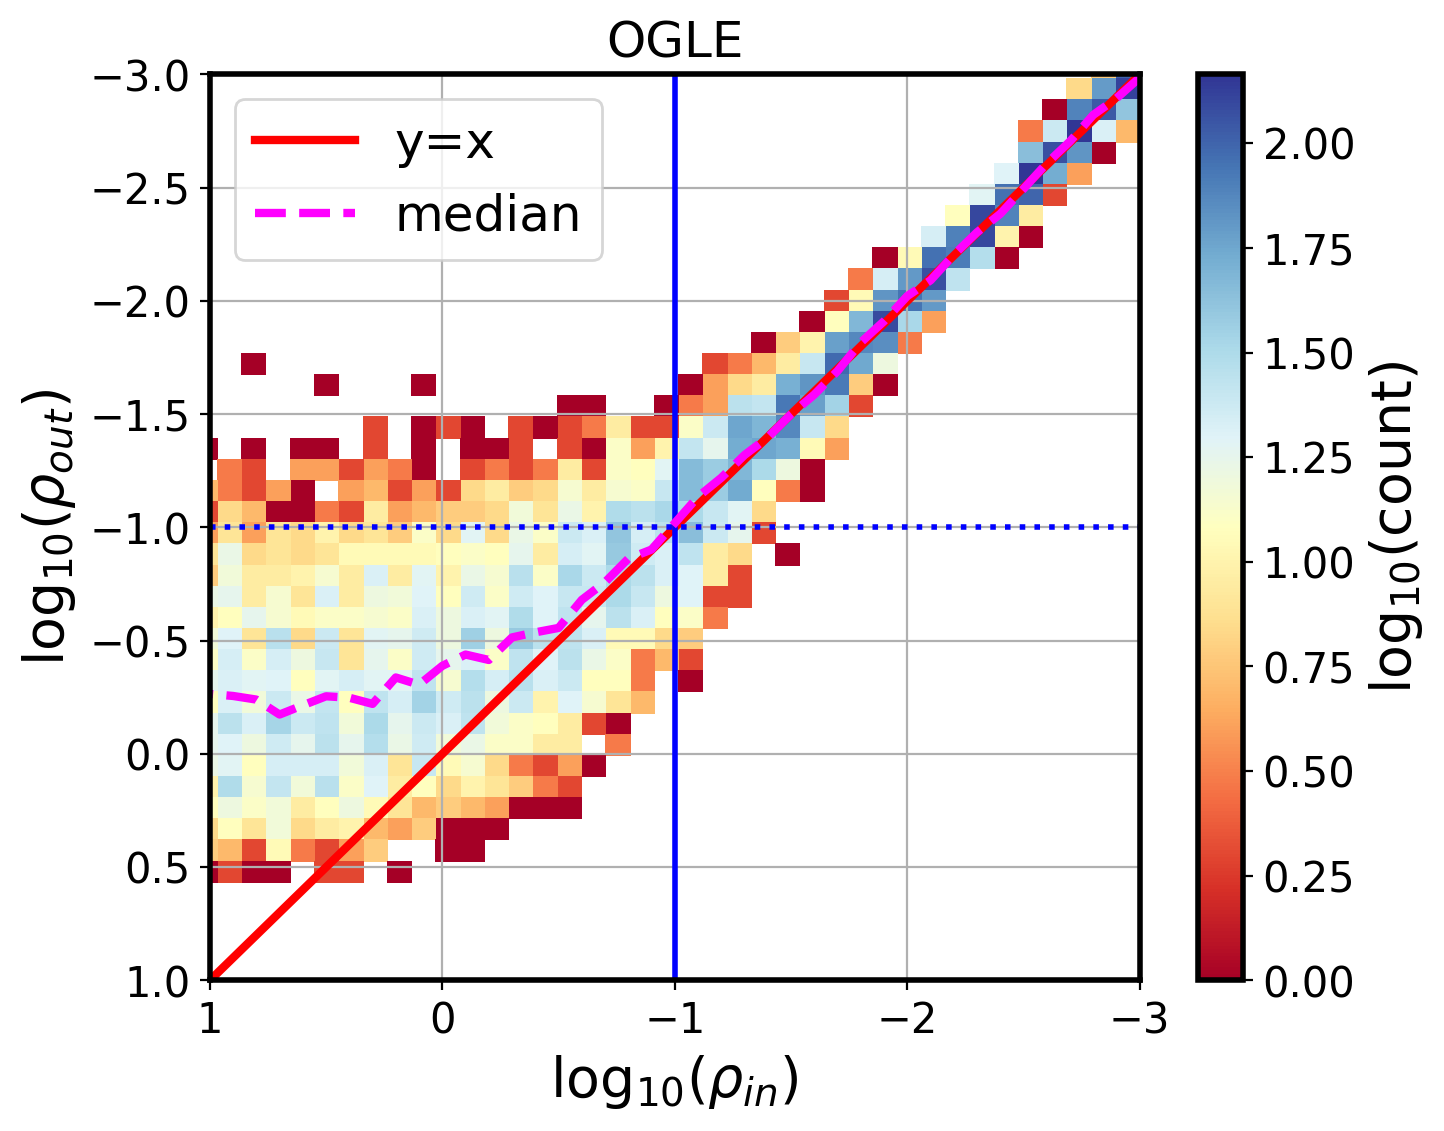

In [19]:
%matplotlib inline
from scipy.stats import binned_statistic_2d

prior='Jeff1'  
# Jeff1 is 1/sigma * 1/tau 
simulation= 'OGLE'#'OGLE'#'SDSS'#'OGLE'# 'SDSS'

if simulation is 'SDSS':
    N = 60
if simulation is 'OGLE':
    N = 445 
engine = 'celerite'
fname = 'Fig_01_'+engine+'_'+prior+'_'+str(int(N))+'_'+simulation+'.txt'
store = Table.read(fname, format='ascii')

%config InlineBackend.figure_format='retina'
#fig = plt.figure(figsize=(10, 5), dpi=100)

t_exp = 8 * 365.0 # days 
rho_in = store['rho_in']

label = 'expectation'
rho_out  = store['tau_EXP'] / t_exp
        
fig,ax = plt.subplots(1,1,figsize=(7.5,6), dpi=100)
x = np.log10(rho_in)
y = np.log10(rho_out)

#bins = np.linspace(min(x),max(x),40)
stats = binned_statistic_2d(x, y, x, statistic='count', bins=40)
z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                         cmap=plt.cm.get_cmap('RdYlBu'))

plt.colorbar(image, label=r'$\log_{10}{(\mathrm{count})}$')
# lines to guide the eye ...
ax.grid()
xlim = ax.get_xlim()
x_line = np.arange(xlim[0], xlim[1],0.01)
ax.plot(x_line,x_line, ls='-', lw=3, color='red', label='y=x')
ax.axhline(-1, ls=':', lw=2, c='blue')
ax.axvline(-1, ls='-', lw=2, c='blue')

# calculate the median of log(rho_out)
# Median of the log(y) is not the log(median(y)) .... 
min_x, max_x , step_size = xlim[0],xlim[1], 0.1
mean_x = np.arange(min_x, max_x+step_size , step_size)
dx = 0.5 * step_size 
median_y = np.zeros(len(mean_x))

for j in range(len(median_y)):
    # take points that are within desired x_data limits for each bin
    # i.e. marginalize along y ( stack vertically)
    mask =  ((mean_x[j] - dx) < x)*(x<  (mean_x[j] + dx))
    median_y[j] = np.median(y[mask])

ax.plot(mean_x[:-1], median_y[:-1], c = 'magenta',lw=3, label='median',
       ls= '--')#, s=50 , edgecolor='black')
# labels...
ax.set_xlabel(r'$\log_{10}(\rho_{in})$')
ax.set_ylabel(r'$\log_{10}(\rho_{out})$')
ax.legend(fontsize=18)
ax.set_title(simulation)
ax.set_ylim(-3,1)
ax.set_xlim(-3,1)
ax.invert_xaxis()
ax.invert_yaxis()
figname = 'Fig_01_'+engine+'_'+simulation+'_'+prior+'_'+label+'-'+where+'R.png'
plt.savefig(figname, bbox_inches='tight')
print('Saved as ', figname)